In [7]:
import torch
torch.enable_grad(False)

# Enable PyTorch performance optimizations
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os
import time
import pandas as pd
from tqdm.auto import tqdm
import argparse
import random

import sys
sys.path.append('../.')
from utils.load_util import load_sdxl_models, load_pipe



distillation_type='dmd'  # what type of distillation model do you want to use ("dmd", "lcm", "turbo", "lightning")
device = 'cuda:0'  # Use CUDA for A100 GPU
weights_dtype = torch.bfloat16  # Use bfloat16 for better performance on A100

pipe, base_unet, base_scheduler, distilled_unet, distilled_scheduler = load_sdxl_models(distillation_type=distillation_type, 
                                                                                        weights_dtype=weights_dtype, 
                                                                                        device=device)

Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.43it/s]


In [8]:
def diversity_distillation(prompt, seed, pipe, base_unet, distilled_unet, distilled_scheduler, base_guidance_scale=5, distilled_guidance_scale=0, num_inference_steps=4, run_base_till=1):
    pipe.scheduler = distilled_scheduler
    pipe.unet=base_unet

    base_latents = pipe(prompt,
                    guidance_scale=base_guidance_scale,
                    till_timestep=run_base_till, 
                    num_inference_steps=num_inference_steps,
                    generator=torch.Generator().manual_seed(seed),
                    output_type='latent'
                   )
    

    pipe.unet = distilled_unet
    images = pipe(prompt,
                 guidance_scale=distilled_guidance_scale,
                 start_latents = base_latents,   
                 num_inference_steps=num_inference_steps,
                 from_timestep=run_base_till,
                 output_type='pil'
                )
    return images

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9/10 [00:01<00:00,  7.67it/s]


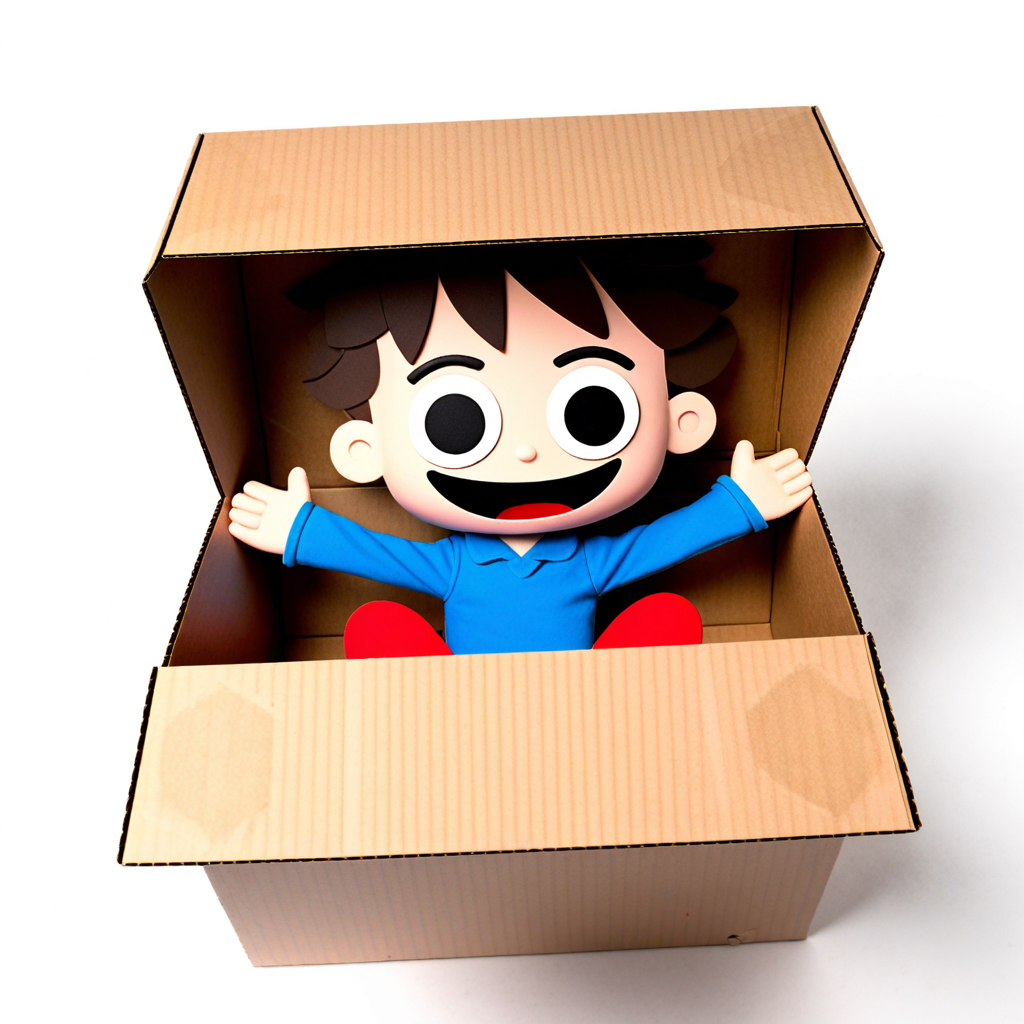

In [9]:
prompt = 'jack in a box'
seed = random.randint(0, 2**15)

images = diversity_distillation(prompt, seed, pipe, base_unet, distilled_unet, distilled_scheduler, num_inference_steps=10)

images[0]




In [10]:
positive_prompt = (
    "natural light editorial headshot of a 28-year-old woman, half-body, slight smile, "
    "subtle pores and fine skin texture, sharp focus, micro-contrast, neutral backdrop, "
    "85mm lens look, shallow depth of field, photorealistic, balanced colours"
)

negative_prompt = (
    "waxy skin, plastic skin, "
    "asymmetrical eyes, cross-eye, extra teeth, fused lips, "
    "text, watermark, logo"
)

seed = 42

# (Good default schedulers for SDXL base in diffusers)
from diffusers import EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# or try: pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

gen = torch.Generator(device=pipe.device).manual_seed(seed)

image_no_neg = pipe(
    positive_prompt,
    guidance_scale=5.5,
    guidance_rescale=0.6,     # <- helps retain natural contrast
    num_inference_steps=32,
    generator=gen,
    output_type="pil",
)[0]

image_with_neg = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    guidance_scale=5.5,
    guidance_rescale=0.6,
    num_inference_steps=32,
    generator=gen,
    output_type="pil",
)[0]

# Display side by side
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image_no_neg)
ax1.set_title("Without Negative Prompt", fontsize=14, fontweight='bold')
ax1.axis('off')

ax2.imshow(image_with_neg)
ax2.set_title("With Negative Prompt", fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Comparison complete!")
print(f"Look for differences: the negative prompt should reduce presence of '{negative_prompt}'")

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/32 [00:00<?, ?it/s]


NameError: name 'rescale_noise_cfg' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to generate images using only the distilled model
def distilled_only_generation(prompt, seed, pipe, distilled_unet, distilled_scheduler, guidance_scale=0, num_inference_steps=4):
    pipe.scheduler = distilled_scheduler
    pipe.unet = distilled_unet
    
    images = pipe(prompt,
                 guidance_scale=guidance_scale,
                 num_inference_steps=num_inference_steps,
                 generator=torch.Generator().manual_seed(seed),
                 output_type='pil'
                )
    return images

# Function to generate images using only the base model
def base_only_generation(prompt, seed, pipe, base_unet, base_scheduler, guidance_scale=5, num_inference_steps=20):
    pipe.scheduler = base_scheduler
    pipe.unet = base_unet
    
    images = pipe(prompt,
                 guidance_scale=guidance_scale,
                 num_inference_steps=num_inference_steps,
                 generator=torch.Generator().manual_seed(seed),
                 output_type='pil'
                )
    return images

# User prompt
prompt = "bear in a top hat"  # Replace with your desired prompt
num_images = 6  # 2x3 grid

# Create output directory
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

nrows = 2
ncols = 3

# Initialize variables
total_time_diversity = 0
total_time_distilled = 0
total_time_base = 0
all_diversity_images = []
all_distilled_images = []
all_base_images = []

pipe.set_progress_bar_config(disable=True)

# Generate images with all three methods
for i in tqdm(range(num_images)):
    # Generate random seed (use same seed for all methods for fair comparison)
    seed = np.random.randint(0, 2**32 - 1)
    
    # Generate diversity distillation image
    start_time = time.perf_counter()
    diversity_image = diversity_distillation(prompt, seed, pipe, base_unet, distilled_unet, distilled_scheduler)[0]
    end_time = time.perf_counter()
    runtime_diversity = end_time - start_time
    total_time_diversity += runtime_diversity
    
    # Generate distilled-only image
    start_time = time.perf_counter()
    distilled_image = distilled_only_generation(prompt, seed, pipe, distilled_unet, distilled_scheduler)[0]
    end_time = time.perf_counter()
    runtime_distilled = end_time - start_time
    total_time_distilled += runtime_distilled
    
    # Generate base-only image
    start_time = time.perf_counter()
    base_image = base_only_generation(prompt, seed, pipe, base_unet, base_scheduler)[0]
    end_time = time.perf_counter()
    runtime_base = end_time - start_time
    total_time_base += runtime_base
    
    # Save individual images to disk
    diversity_filename = f"{output_dir}/diversity_image_{i+1:02d}_seed_{seed}.png"
    distilled_filename = f"{output_dir}/distilled_image_{i+1:02d}_seed_{seed}.png"
    base_filename = f"{output_dir}/base_image_{i+1:02d}_seed_{seed}.png"
    diversity_image.save(diversity_filename)
    distilled_image.save(distilled_filename)
    base_image.save(base_filename)
    
    # Append to lists for grid creation
    all_diversity_images.append(diversity_image)
    all_distilled_images.append(distilled_image)
    all_base_images.append(base_image)

# Create comparison figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(ncols*9, nrows*3), dpi=200)

# Create grid for diversity distillation images
ax1.set_title("Diversity Distillation\n(Base + Distilled)", fontsize=14, pad=20)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j
        if idx < len(all_diversity_images):
            # Calculate position for each image in the grid
            y_start = (nrows - 1 - i) / nrows
            y_end = (nrows - i) / nrows
            x_start = j / ncols
            x_end = (j + 1) / ncols
            
            # Create inset axes for each image
            img_ax = ax1.inset_axes([x_start, y_start, x_end - x_start, y_end - y_start])
            img_ax.imshow(all_diversity_images[idx])
            img_ax.axis('off')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

# Create grid for distilled-only images
ax2.set_title("Distilled Model Only\n(4 steps)", fontsize=14, pad=20)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j
        if idx < len(all_distilled_images):
            # Calculate position for each image in the grid
            y_start = (nrows - 1 - i) / nrows
            y_end = (nrows - i) / nrows
            x_start = j / ncols
            x_end = (j + 1) / ncols
            
            # Create inset axes for each image
            img_ax = ax2.inset_axes([x_start, y_start, x_end - x_start, y_end - y_start])
            img_ax.imshow(all_distilled_images[idx])
            img_ax.axis('off')

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

# Create grid for base-only images
ax3.set_title("Base Model Only\n(20 steps)", fontsize=14, pad=20)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j
        if idx < len(all_base_images):
            # Calculate position for each image in the grid
            y_start = (nrows - 1 - i) / nrows
            y_end = (nrows - i) / nrows
            x_start = j / ncols
            x_end = (j + 1) / ncols
            
            # Create inset axes for each image
            img_ax = ax3.inset_axes([x_start, y_start, x_end - x_start, y_end - y_start])
            img_ax.imshow(all_base_images[idx])
            img_ax.axis('off')

ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')

plt.tight_layout()

# Print timing information
print(f"Diversity Distillation - Total Runtime: {total_time_diversity:.4f} seconds")
print(f"Diversity Distillation - Average per image: {total_time_diversity/num_images:.4f} seconds")
print(f"Distilled Only - Total Runtime: {total_time_distilled:.4f} seconds")
print(f"Distilled Only - Average per image: {total_time_distilled/num_images:.4f} seconds")
print(f"Base Only - Total Runtime: {total_time_base:.4f} seconds")
print(f"Base Only - Average per image: {total_time_base/num_images:.4f} seconds")
print(f"Individual images saved to: {output_dir}/")

# Save the comparison grid
comparison_filename = f"{output_dir}/three_way_comparison_{prompt.replace(' ', '_')}.png"
plt.savefig(comparison_filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
print(f"Three-way comparison grid saved to: {comparison_filename}")

plt.show()

# Multi-Model Diversity Comparison

Compare diversity across three different distillation models: DMD, Lightning, and Turbo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tqdm.auto import tqdm

# Configuration
prompt = "frog in a hat"
num_images = 6  # 2x3 grid
nrows = 2
ncols = 3

# Models to compare
model_types = ['dmd', 'lightning', 'turbo']
model_names = {
    'dmd': 'DMD',
    'lightning': 'Lightning', 
    'turbo': 'Turbo'
}

# Create output directory
output_dir = "multi_model_comparison"
os.makedirs(output_dir, exist_ok=True)

# Store results for each model and method
all_results = {}
timing_results = {}

print(f"Comparing 3 generation methods across {len(model_types)} models: {', '.join(model_names.values())}")
print(f"Generating {num_images} images per method per model with prompt: '{prompt}'\n")

# Load and test each model
for model_type in model_types:
    print(f"\n{'='*60}")
    print(f"Loading {model_names[model_type]} model...")
    print(f"{'='*60}")
    
    # Load the model
    start_load = time.time()
    model_pipe, model_base_unet, model_base_scheduler, model_distilled_unet, model_distilled_scheduler = load_sdxl_models(
        distillation_type=model_type,
        weights_dtype=torch.bfloat16,
        device=device
    )
    load_time = time.time() - start_load
    print(f"✓ {model_names[model_type]} loaded in {load_time:.2f}s")
    
    # Initialize storage for this model
    all_results[model_type] = {
        'diversity': [],
        'distilled': [],
        'base': []
    }
    timing_results[model_type] = {
        'diversity': {'total': 0, 'average': 0},
        'distilled': {'total': 0, 'average': 0},
        'base': {'total': 0, 'average': 0},
        'load_time': load_time
    }
    
    model_pipe.set_progress_bar_config(disable=True)
    
    # Generate images with all three methods
    for i in tqdm(range(num_images), desc=f"Generating {model_names[model_type]} images"):
        # Use same seed for all methods for fair comparison
        seed = np.random.randint(0, 2**32 - 1)
        
        # 1. Diversity Distillation (Base + Distilled)
        start_time = time.perf_counter()
        diversity_images = diversity_distillation(
            prompt, seed, model_pipe, 
            model_base_unet, model_distilled_unet, 
            model_distilled_scheduler
        )
        gen_time = time.perf_counter() - start_time
        timing_results[model_type]['diversity']['total'] += gen_time
        all_results[model_type]['diversity'].append(diversity_images[0])
        
        # Save individual image
        diversity_filename = f"{output_dir}/{model_type}_diversity_{i+1:02d}_seed_{seed}.png"
        diversity_images[0].save(diversity_filename)
        
        # 2. Distilled Model Only
        start_time = time.perf_counter()
        distilled_images = distilled_only_generation(
            prompt, seed, model_pipe,
            model_distilled_unet, model_distilled_scheduler
        )
        gen_time = time.perf_counter() - start_time
        timing_results[model_type]['distilled']['total'] += gen_time
        all_results[model_type]['distilled'].append(distilled_images[0])
        
        # Save individual image
        distilled_filename = f"{output_dir}/{model_type}_distilled_{i+1:02d}_seed_{seed}.png"
        distilled_images[0].save(distilled_filename)
        
        # 3. Base Model Only
        start_time = time.perf_counter()
        base_images = base_only_generation(
            prompt, seed, model_pipe,
            model_base_unet, model_base_scheduler
        )
        gen_time = time.perf_counter() - start_time
        timing_results[model_type]['base']['total'] += gen_time
        all_results[model_type]['base'].append(base_images[0])
        
        # Save individual image
        base_filename = f"{output_dir}/{model_type}_base_{i+1:02d}_seed_{seed}.png"
        base_images[0].save(base_filename)
    
    # Calculate averages
    for method in ['diversity', 'distilled', 'base']:
        timing_results[model_type][method]['average'] = timing_results[model_type][method]['total'] / num_images
    
    print(f"✓ Generated {num_images*3} images total ({num_images} per method)")
    
    # Clean up to free memory
    del model_pipe, model_base_unet, model_base_scheduler, model_distilled_unet, model_distilled_scheduler
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("Creating comparison visualization...")
print(f"{'='*60}\n")

# Create comparison figure: 3 rows (methods) x 3 columns (models)
fig, axes = plt.subplots(3, 3, figsize=(ncols*10, nrows*11), dpi=200)

method_labels = {
    'diversity': 'Diversity Distillation\n(Base + Distilled)',
    'distilled': 'Distilled Model Only\n(4 steps)',
    'base': 'Base Model Only\n(20 steps)'
}
methods = ['diversity', 'distilled', 'base']

# Create grid for each combination of method and model
for method_idx, method in enumerate(methods):
    for model_idx, model_type in enumerate(model_types):
        ax = axes[method_idx, model_idx]
        model_name = model_names[model_type]
        avg_time = timing_results[model_type][method]['average']
        
        # Title includes model name, method, and timing
        if method_idx == 0:  # Top row gets model name
            title = f"{model_name}\n{method_labels[method]}\n{avg_time:.2f}s/img"
        else:
            title = f"{method_labels[method]}\n{avg_time:.2f}s/img"
        
        ax.set_title(title, fontsize=12, pad=15, fontweight='bold')
        
        # Create grid for this method's images
        for i in range(nrows):
            for j in range(ncols):
                idx = i * ncols + j
                if idx < len(all_results[model_type][method]):
                    # Calculate position for each image in the grid
                    y_start = (nrows - 1 - i) / nrows
                    y_end = (nrows - i) / nrows
                    x_start = j / ncols
                    x_end = (j + 1) / ncols
                    
                    # Create inset axes for each image
                    img_ax = ax.inset_axes([x_start, y_start, x_end - x_start, y_end - y_start])
                    img_ax.imshow(all_results[model_type][method][idx])
                    img_ax.axis('off')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')

plt.tight_layout()

# Print comprehensive timing information
print("\n" + "="*60)
print("TIMING RESULTS")
print("="*60)
for model_type in model_types:
    model_name = model_names[model_type]
    results = timing_results[model_type]
    print(f"\n{model_name} (Load time: {results['load_time']:.2f}s):")
    print(f"  Diversity Distillation:")
    print(f"    Total: {results['diversity']['total']:.2f}s | Avg: {results['diversity']['average']:.2f}s | Throughput: {1.0/results['diversity']['average']:.2f} img/s")
    print(f"  Distilled Only:")
    print(f"    Total: {results['distilled']['total']:.2f}s | Avg: {results['distilled']['average']:.2f}s | Throughput: {1.0/results['distilled']['average']:.2f} img/s")
    print(f"  Base Only:")
    print(f"    Total: {results['base']['total']:.2f}s | Avg: {results['base']['average']:.2f}s | Throughput: {1.0/results['base']['average']:.2f} img/s")

print(f"\nIndividual images saved to: {output_dir}/")

# Save the comparison grid
comparison_filename = f"{output_dir}/full_comparison_{prompt.replace(' ', '_')}.png"
plt.savefig(comparison_filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
print(f"Full comparison grid saved to: {comparison_filename}")

plt.show()

print("\n✅ Multi-model multi-method comparison complete!")
print(f"Total images generated: {len(model_types) * 3 * num_images} ({len(model_types)} models × 3 methods × {num_images} images)")

Comparing 3 generation methods across 3 models: DMD, Lightning, Turbo
Generating 6 images per method per model with prompt: 'frog in a hat'


Loading DMD model...


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'load_sdxl_models' is not defined

# CFG and Negative Prompt Testing

Test how different distillation models respond to:
- Different CFG (Classifier-Free Guidance) scales
- Negative prompts for unwanted features

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# Configuration - More compositional prompts for clearer negative testing
positive_prompt = "horse pulling a carriage"
negative_prompt = "wheels"  # Compositional: opposite objects/attributes
seed = 42  # Fixed seed for consistency

# CFG scales to test
cfg_scales = [0.0, 2.5, 5.0, 7.5, 10.0]  # Test range from no guidance to high guidance

# All 8 distillation models plus base
model_types = ['base', 'dmd', 'turbo', 'lightning', 'lcm', 'hyper', 'pcm', 'tcd', 'flash']
model_names = {
    'base': 'Base SDXL',
    'dmd': 'DMD2',
    'turbo': 'SDXL-Turbo',
    'lightning': 'SDXL-Lightning',
    'lcm': 'LCM-LoRA',
    'hyper': 'Hyper-SDXL',
    'pcm': 'PCM',
    'tcd': 'TCD',
    'flash': 'Flash Diffusion'
}

# Recommended settings per model
model_configs = {
    'base': {'steps': 20, 'recommended_cfg': 5.0},
    'dmd': {'steps': 4, 'recommended_cfg': 0.0},
    'turbo': {'steps': 1, 'recommended_cfg': 0.0},
    'lightning': {'steps': 4, 'recommended_cfg': 0.0},
    'lcm': {'steps': 4, 'recommended_cfg': 1.0},
    'hyper': {'steps': 8, 'recommended_cfg': 5.0},  # CFG-preserved version
    'pcm': {'steps': 4, 'recommended_cfg': 2.0},
    'tcd': {'steps': 4, 'recommended_cfg': 3.0},  # Supports standard CFG
    'flash': {'steps': 4, 'recommended_cfg': 2.0}
}

output_dir = "test-output"
os.makedirs(output_dir, exist_ok=True)

# Store results
all_results = {
    'cfg_sweep': {},  # CFG scale responses
    'negative_test': {}  # Negative prompt effectiveness
}

print("="*80)
print("COMPREHENSIVE CFG & COMPOSITIONAL NEGATIVE PROMPT TESTING")
print("="*80)
print(f"Positive Prompt: {positive_prompt}")
print(f"Negative Prompt: {negative_prompt}")
print(f"Seed: {seed}")
print(f"Testing {len(model_types)} models\n")

# Test each model
for model_type in model_types:
    print(f"\n{'='*80}")
    print(f"Testing {model_names[model_type]} model...")
    print(f"{'='*80}")
    
    # Load the model
    if model_type == 'base':
        # Base model doesn't need distillation loading
        test_pipe, test_base_unet, test_base_scheduler, _, _ = load_sdxl_models(
            distillation_type='dmd',  # Dummy, we'll use base components
            weights_dtype=torch.bfloat16,
            device=device
        )
        test_unet = test_base_unet
        test_scheduler = test_base_scheduler
    else:
        test_pipe, test_base_unet, test_base_scheduler, test_distilled_unet, test_distilled_scheduler = load_sdxl_models(
            distillation_type=model_type,
            weights_dtype=torch.bfloat16,
            device=device
        )
        test_unet = test_distilled_unet
        test_scheduler = test_distilled_scheduler
    
    test_pipe.set_progress_bar_config(disable=True)
    config = model_configs[model_type]
    
    all_results['cfg_sweep'][model_type] = []
    all_results['negative_test'][model_type] = {}
    
    # Test 1: CFG Scale Sweep
    print(f"\n1. Testing CFG scale response (recommended: {config['recommended_cfg']})...")
    for cfg in cfg_scales:
        test_pipe.scheduler = test_scheduler
        test_pipe.unet = test_unet
        
        image = test_pipe(
            positive_prompt,
            guidance_scale=cfg,
            num_inference_steps=config['steps'],
            generator=torch.Generator().manual_seed(seed),
            output_type='pil'
        )[0]
        
        all_results['cfg_sweep'][model_type].append((cfg, image))
        print(f"  ✓ CFG={cfg}")
    
    # Test 2: Negative Prompt at Recommended CFG
    print(f"\n2. Testing negative prompt effectiveness at CFG={config['recommended_cfg']}...")
    test_pipe.scheduler = test_scheduler
    test_pipe.unet = test_unet
    
    # Without negative prompt
    image_no_neg = test_pipe(
        positive_prompt,
        guidance_scale=config['recommended_cfg'],
        num_inference_steps=config['steps'],
        generator=torch.Generator().manual_seed(seed),
        output_type='pil'
    )[0]
    
    # With negative prompt
    image_with_neg = test_pipe(
        positive_prompt,
        negative_prompt=negative_prompt,
        guidance_scale=config['recommended_cfg'],
        num_inference_steps=config['steps'],
        generator=torch.Generator().manual_seed(seed),
        output_type='pil'
    )[0]
    
    all_results['negative_test'][model_type]['without'] = image_no_neg
    all_results['negative_test'][model_type]['with'] = image_with_neg
    print(f"  ✓ Generated both versions")
    
    # Clean up
    del test_pipe, test_base_unet, test_base_scheduler, test_unet, test_scheduler
    if model_type != 'base':
        del test_distilled_unet, test_distilled_scheduler
    torch.cuda.empty_cache()

print(f"\n{'='*80}")
print("Creating visualizations...")
print(f"{'='*80}\n")

# Visualization 1: CFG Scale Comparison Grid (9 models x 5 CFG values)
fig, axes = plt.subplots(len(model_types), len(cfg_scales), figsize=(25, len(model_types)*4), dpi=150)
fig.suptitle(f'CFG Scale Response Across All Models\nPrompt: "{positive_prompt}"', 
             fontsize=18, fontweight='bold', y=0.995)

for model_idx, model_type in enumerate(model_types):
    model_name = model_names[model_type]
    rec_cfg = model_configs[model_type]['recommended_cfg']
    
    for cfg_idx, (cfg, img) in enumerate(all_results['cfg_sweep'][model_type]):
        ax = axes[model_idx, cfg_idx]
        ax.imshow(img)
        
        # Highlight recommended CFG with green border
        if cfg == rec_cfg:
            title = f'CFG={cfg}★'
            ax.spines['bottom'].set_color('green')
            ax.spines['top'].set_color('green')
            ax.spines['left'].set_color('green')
            ax.spines['right'].set_color('green')
            ax.spines['bottom'].set_linewidth(4)
            ax.spines['top'].set_linewidth(4)
            ax.spines['left'].set_linewidth(4)
            ax.spines['right'].set_linewidth(4)
        else:
            title = f'CFG={cfg}'
        
        ax.set_title(title, fontsize=11)
        ax.axis('off')
        
        # Add model name on first column
        if cfg_idx == 0:
            ax.text(-0.1, 0.5, model_name, transform=ax.transAxes, 
                   fontsize=12, fontweight='bold', va='center', ha='right', rotation=0)

plt.tight_layout()
cfg_sweep_filename = f"{output_dir}/all_models_cfg_sweep.png"
plt.savefig(cfg_sweep_filename, bbox_inches='tight', dpi=150)
print(f"✓ Saved CFG sweep: {cfg_sweep_filename}")
plt.show()

# Visualization 2: Negative Prompt Effectiveness (9 models x 2 conditions)
fig, axes = plt.subplots(len(model_types), 2, figsize=(12, len(model_types)*3), dpi=150)
fig.suptitle(f'Negative Prompt Effectiveness Test\nPositive: "{positive_prompt}"\nNegative: "{negative_prompt}"', 
             fontsize=16, fontweight='bold', y=0.995)

for model_idx, model_type in enumerate(model_types):
    model_name = model_names[model_type]
    rec_cfg = model_configs[model_type]['recommended_cfg']
    
    # Without negative
    ax = axes[model_idx, 0]
    ax.imshow(all_results['negative_test'][model_type]['without'])
    ax.set_title(f'Without Negative\n(CFG={rec_cfg})', fontsize=11)
    ax.axis('off')
    
    # With negative
    ax = axes[model_idx, 1]
    ax.imshow(all_results['negative_test'][model_type]['with'])
    ax.set_title(f'With Negative\n(CFG={rec_cfg})', fontsize=11)
    ax.axis('off')
    
    # Add model name
    axes[model_idx, 0].text(-0.15, 0.5, model_name, transform=axes[model_idx, 0].transAxes, 
                           fontsize=12, fontweight='bold', va='center', ha='right', rotation=0)

plt.tight_layout()
negative_test_filename = f"{output_dir}/all_models_negative_prompt_test.png"
plt.savefig(negative_test_filename, bbox_inches='tight', dpi=150)
print(f"✓ Saved negative prompt test: {negative_test_filename}")
plt.show()

print("\n✅ Comprehensive CFG and negative prompt testing complete!")
print(f"\nKey Observations to Look For:")
print("- Base SDXL: Should show strong CFG response and negative prompt adherence")
print("- DMD2/Turbo/Lightning: Minimal CFG response (optimized for CFG=0)")
print("- LCM: Slight CFG response at w∈[1,2]")
print("- Hyper-SDXL: Should maintain CFG response (CFG-preserved LoRA)")
print("- PCM/TCD: Designed for multi-step with CFG support")
print("- Flash: Adapter-based, check CFG/negative compatibility")
print(f"\nNegative prompt test: Look for absence of 'dog', 'blue', 'metal', 'standing'")
print(f"                      Should preserve 'cat', 'red hat', 'wooden chair', 'sitting'")

COMPREHENSIVE CFG & COMPOSITIONAL NEGATIVE PROMPT TESTING
Positive Prompt: horse pulling a carriage
Negative Prompt: wheels
Seed: 42
Testing 9 models


Testing Base SDXL model...


Loading pipeline components...:  29%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/7 [00:00<00:01,  4.10it/s]

Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.75it/s]



1. Testing CFG scale response (recommended: 5.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=5.0...
  ✓ Generated both versions

Testing DMD2 model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.59it/s]



1. Testing CFG scale response (recommended: 0.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=0.0...
  ✓ Generated both versions

Testing SDXL-Turbo model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.01it/s]



1. Testing CFG scale response (recommended: 0.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=0.0...
  ✓ Generated both versions

Testing SDXL-Lightning model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.59it/s]



1. Testing CFG scale response (recommended: 0.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=0.0...
  ✓ Generated both versions

Testing LCM-LoRA model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.08it/s]



1. Testing CFG scale response (recommended: 1.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=1.0...
  ✓ Generated both versions

Testing Hyper-SDXL model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.31it/s]



1. Testing CFG scale response (recommended: 5.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=5.0...
  ✓ Generated both versions

Testing PCM model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.93it/s]



1. Testing CFG scale response (recommended: 2.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=2.0...
  ✓ Generated both versions

Testing TCD model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.25it/s]



1. Testing CFG scale response (recommended: 3.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=3.0...
  ✓ Generated both versions

Testing Flash Diffusion model...


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.36it/s]



1. Testing CFG scale response (recommended: 2.0)...
  ✓ CFG=0.0
  ✓ CFG=1.0
  ✓ CFG=3.0
  ✓ CFG=5.0
  ✓ CFG=7.0

2. Testing negative prompt effectiveness at CFG=2.0...
  ✓ Generated both versions

Creating visualizations...

